<a href="https://colab.research.google.com/github/amarabuco/am-pos-2020-2/blob/main/Atividade_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import  MinMaxScaler, StandardScaler
from sklearn.neural_network import MLPClassifier


import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose


import matplotlib.pyplot as plt
import seaborn as sns

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/bc/Haliotis_tuberculata_coccinea_01.JPG/800px-Haliotis_tuberculata_coccinea_01.JPG" width='300'/>

# Data Set Information:

Predicting the age of abalone from physical measurements. The age of abalone is determined by cutting the shell through the cone, staining it, and counting the number of rings through a microscope -- a boring and time-consuming task. Other measurements, which are easier to obtain, are used to predict the age. Further information, such as weather patterns and location (hence food availability) may be required to solve the problem.

From the original data examples with missing values were removed (the majority having the predicted value missing), and the ranges of the continuous values have been scaled for use with an ANN (by dividing by 200).


Attribute Information:

Given is the attribute name, attribute type, the measurement unit and a brief description. **The number of rings is the value to predict: either as a continuous value or as a classification problem.**

Name / Data Type / Measurement Unit / Description
-----------------------------
* Sex / nominal / -- / M, F, and I (infant)
* Length / continuous / mm / Longest shell measurement
* Diameter / continuous / mm / perpendicular to length
* Height / continuous / mm / with meat in shell
* Whole weight / continuous / grams / whole abalone
* Shucked weight / continuous / grams / weight of meat
* Viscera weight / continuous / grams / gut weight (after bleeding)
* Shell weight / continuous / grams / after being dried
* Rings / integer / -- / +1.5 gives the age in years

The readme file contains attribute statistics.

In [ ]:
colunas = ['sex', 'length', 'diameter', 'height', 'whole_weight', 'shucked_weight', 'viscera_weight', 'shell_weight', 'rings']
dataset = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data', names=colunas)
dataset.head()

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


# Pre-processamento

In [ ]:
X = dataset[dataset.columns[0:-1]]
y = pd.Series(dataset['rings'])

In [ ]:
X['sex'].replace({'I':0,'F':-1,'M':1}, inplace=True)

In [ ]:
scaler = StandardScaler()
X[X.columns[1:]] = pd.DataFrame(scaler.fit_transform(X[X.columns[1:]]), columns=colunas[1:-1])

In [ ]:
X.head()

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight
0,1,-0.574558,-0.432149,-1.064424,-0.641898,-0.607685,-0.726212,-0.638217
1,1,-1.448986,-1.439929,-1.183978,-1.230277,-1.170910,-1.205221,-1.212987
2,-1,0.050033,0.122130,-0.107991,-0.309469,-0.463500,-0.356690,-0.207139
3,1,-0.699476,-0.432149,-0.347099,-0.637819,-0.648238,-0.607600,-0.602294
4,0,-1.615544,-1.540707,-1.423087,-1.272086,-1.215968,-1.287337,-1.320757


In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   sex             4177 non-null   int64  
 1   length          4177 non-null   float64
 2   diameter        4177 non-null   float64
 3   height          4177 non-null   float64
 4   whole_weight    4177 non-null   float64
 5   shucked_weight  4177 non-null   float64
 6   viscera_weight  4177 non-null   float64
 7   shell_weight    4177 non-null   float64
dtypes: float64(7), int64(1)
memory usage: 261.2 KB


In [ ]:
dataset.describe()

,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831,9.933684
std,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203,3.224169
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000,8.000000
50%,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000,9.000000
75%,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000,11.000000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


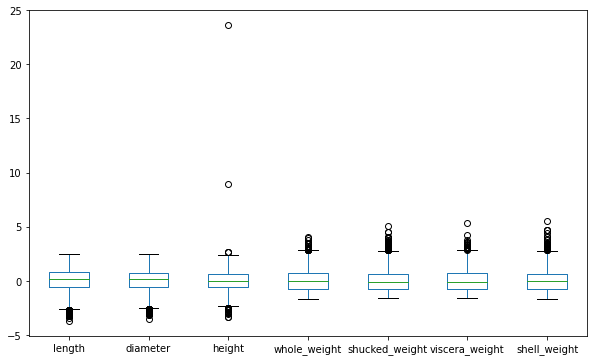

In [ ]:
X[X.columns[1:]].plot.box(figsize=(10,6))

In [ ]:
X.corr()

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight
sex,1.000000,-0.036066,-0.038874,-0.042077,-0.021391,-0.001373,-0.032067,-0.034854
length,-0.036066,1.000000,0.986812,0.827554,0.925261,0.897914,0.903018,0.897706
diameter,-0.038874,0.986812,1.000000,0.833684,0.925452,0.893162,0.899724,0.905330
height,-0.042077,0.827554,0.833684,1.000000,0.819221,0.774972,0.798319,0.817338
whole_weight,-0.021391,0.925261,0.925452,0.819221,1.000000,0.969405,0.966375,0.955355
shucked_weight,-0.001373,0.897914,0.893162,0.774972,0.969405,1.000000,0.931961,0.882617
viscera_weight,-0.032067,0.903018,0.899724,0.798319,0.966375,0.931961,1.000000,0.907656
shell_weight,-0.034854,0.897706,0.905330,0.817338,0.955355,0.882617,0.907656,1.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f00abbc91d0>,
      dtype=object)

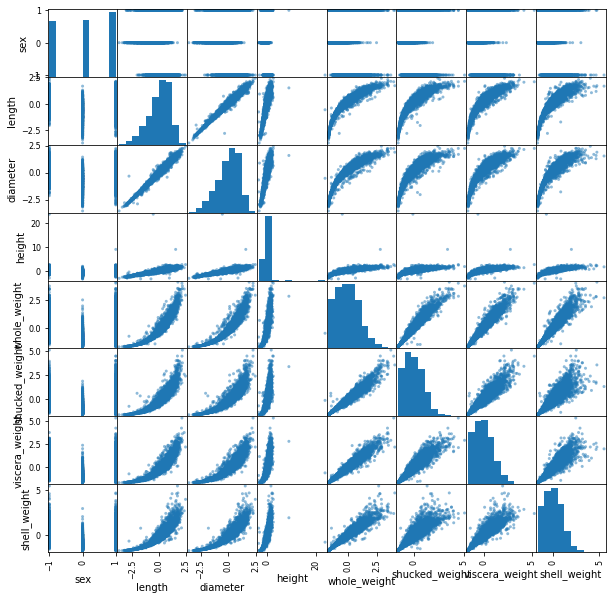

In [ ]:
pd.plotting.scatter_matrix(X, figsize=(10,10))

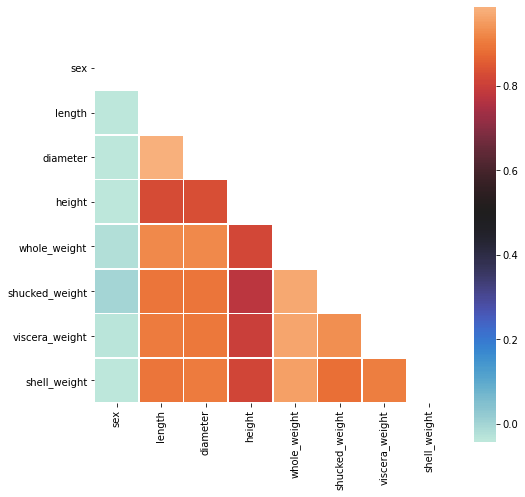

In [ ]:
mask = np.zeros_like(dataset.corr()) 
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(8, 8))
ax = sns.heatmap(X.corr(), mask=mask, center=0.5, square=True, linewidths=.5)

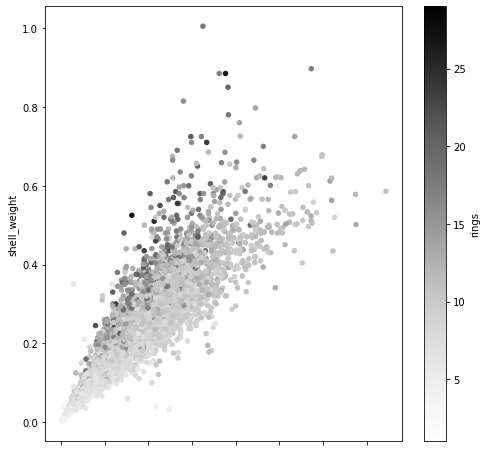

In [ ]:
dataset.plot.scatter(x='shucked_weight', y='shell_weight', c='rings', figsize=(8,8))

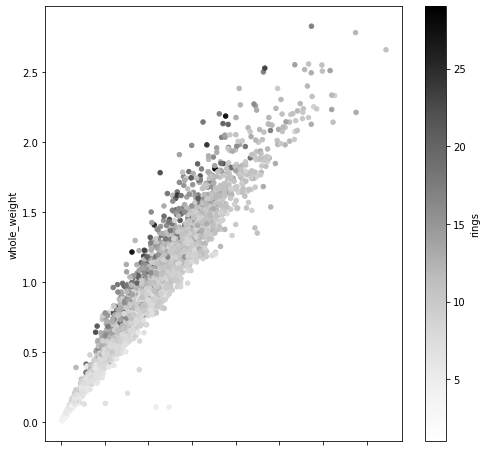

In [ ]:
dataset.plot.scatter(x='shucked_weight', y='whole_weight', c='rings', figsize=(8,8))

# ANN

### identity

Definição
* identity: no-op activation, useful to implement linear bottleneck, returns f(x) = x

In [ ]:
clf_id = MLPClassifier(hidden_layer_sizes=(10,1), activation='identity', random_state=1)

In [ ]:
parameters = {'solver': ['lbfgs', 'sgd', 'adam'],'alpha': [10 ** -x for x in list(range(1,7))] }

In [ ]:
grid = GridSearchCV(clf_id, parameters)

In [ ]:
grid.fit(X,y)

GridSearchCV(cv=None, error_score=nan,
             estimator=MLPClassifier(activation='identity', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(10, 1),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_fun=15000,
                                     max_iter=200, momentum=0.9,
                                     n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_state=1, shuffle=True,
                                     solver='adam', tol=0.0001,
                                     validation_fraction=0.1, verbose=False,
                                     warm_start=False),
             iid='deprecated', n_jobs=None,
             param_

In [ ]:
grid_id = grid

In [ ]:
grid.best_params_

{'alpha': 0.1, 'solver': 'lbfgs'}

In [ ]:
grid.best_estimator_

MLPClassifier(activation='identity', alpha=0.1, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(10, 1), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=1, shuffle=True, solver='lbfgs',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [ ]:
df_grid = pd.DataFrame({'alpha': grid.cv_results_['param_alpha'], 'solver': grid.cv_results_['param_solver'], 'score': grid.cv_results_['mean_test_score']})
mx_grid = df_grid.pivot(index='alpha', columns = 'solver')

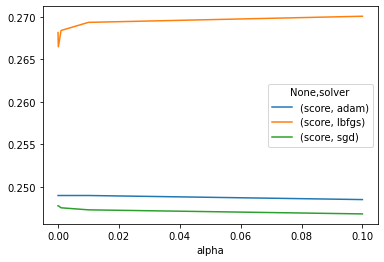

In [ ]:
mx_grid.plot()

Observa-se que o hiperparâmetro solver obteve melhor performance com a opção lbfgs.

In [ ]:
%%time
cv_id = cross_validate(grid.best_estimator_, X, y, cv=10, scoring=['accuracy','f1_micro'], return_train_score=True)

CPU times: user 23.3 s, sys: 18.3 s, total: 41.6 s
Wall time: 21.4 s


In [ ]:
df_id = pd.DataFrame(cv_id).agg(['mean','std'])
df_id['activation'] = 'id'
df_id

,fit_time,score_time,test_accuracy,train_accuracy,test_f1_micro,train_f1_micro,activation
mean,2.118917,0.003889,0.268138,0.272178,0.268138,0.272178,id
std,0.098729,0.000198,0.024815,0.003369,0.024815,0.003369,id


Resultado

### logistic

Definição
* logistic: the logistic sigmoid function, returns f(x) = 1 / (1 + exp(-x)).

In [ ]:
clf_log = MLPClassifier(solver= 'lbfgs', activation= 'logistic', random_state=1)

In [ ]:
parameters = {'hidden_layer_sizes':[(10),(10,10),(10,10,10)], 'alpha': [10 ** -x for x in list(range(1,7))] }

In [ ]:
grid = GridSearchCV(clf_log, parameters)

In [ ]:
%%time
grid.fit(X,y)

CPU times: user 4min 27s, sys: 3min 13s, total: 7min 41s
Wall time: 3min 55s


GridSearchCV(cv=None, error_score=nan,
             estimator=MLPClassifier(activation='logistic', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_fun=15000,
                                     max_iter=200, momentum=0.9,
                                     n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_state=1, shuffle=True,
                                     solver='lbfgs', tol=0.0001,
                                     validation_fraction=0.1, verbose=False,
                                     warm_start=False),
             iid='deprecated', n_jobs=None,
             param_

In [ ]:
grid_log = grid

In [ ]:
grid.best_params_

{'alpha': 0.1, 'hidden_layer_sizes': (10, 10, 10)}

In [ ]:
grid.best_estimator_

MLPClassifier(activation='logistic', alpha=0.1, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(10, 10, 10), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=1, shuffle=True, solver='lbfgs',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [ ]:
df_grid = pd.DataFrame({'alpha': grid_log.cv_results_['param_alpha'], 'layers': grid_log.cv_results_['param_hidden_layer_sizes'], 'score': grid_log.cv_results_['mean_test_score']})
mx_grid = df_grid.pivot(index='alpha', columns = 'layers')

In [ ]:
mx_grid

score                       
layers          10  (10, 10) (10, 10, 10)
alpha                                    
0.000001  0.266700  0.268857     0.273408
0.000010  0.263111  0.268142     0.272211
0.000100  0.263350  0.269340     0.274124
0.001000  0.265266  0.269573     0.273406
0.010000  0.262632  0.269335     0.276279
0.100000  0.263829  0.266467     0.279149

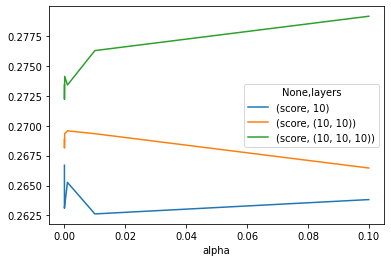

In [ ]:
mx_grid.plot()

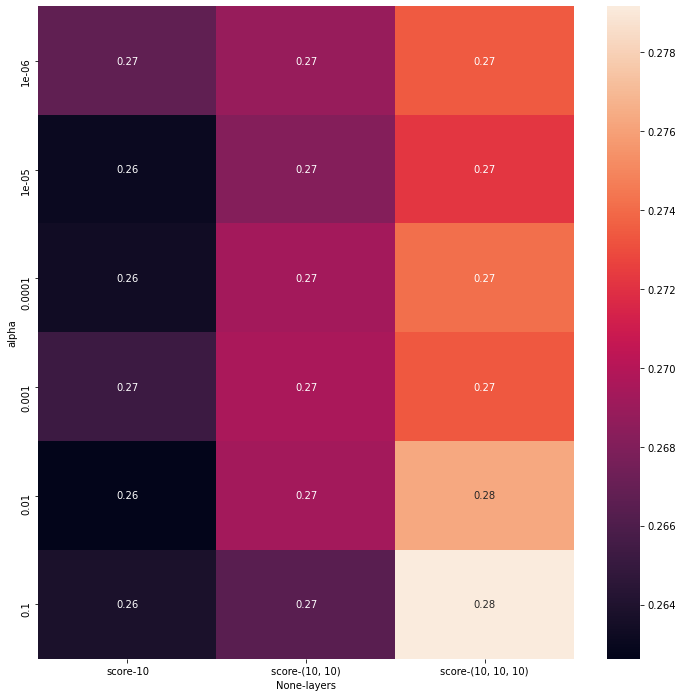

In [ ]:
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(mx_grid, annot=True)
plt.show()

In [ ]:
%%time
cv_log = cross_validate(grid.best_estimator_, X, y, cv=10, scoring=['accuracy','f1_micro'], return_train_score=True)

CPU times: user 39.9 s, sys: 27.6 s, total: 1min 7s
Wall time: 34.4 s


In [ ]:
df_log = pd.DataFrame(cv_log).agg(['mean','std'])
df_log['activation'] = 'log'

Resultado

### tanh

Definição
* tanh: the hyperbolic tan function, returns f(x) = tanh(x).


In [ ]:
clf_tanh = MLPClassifier( solver = 'lbfgs', activation= 'tanh' ,random_state=1)

In [ ]:
parameters = {'hidden_layer_sizes':[(10),(10,10),(10,10,10)], 'alpha': [10 ** -x for x in list(range(1,7))] }

In [ ]:
grid = GridSearchCV(clf_tanh, parameters)

In [ ]:
%%time
grid.fit(X,y)

CPU times: user 4min 55s, sys: 3min 32s, total: 8min 27s
Wall time: 4min 19s


GridSearchCV(cv=None, error_score=nan,
             estimator=MLPClassifier(activation='tanh', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_fun=15000,
                                     max_iter=200, momentum=0.9,
                                     n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_state=1, shuffle=True,
                                     solver='lbfgs', tol=0.0001,
                                     validation_fraction=0.1, verbose=False,
                                     warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid

In [ ]:
grid_tanh = grid

In [ ]:
grid.best_params_

{'alpha': 0.1, 'hidden_layer_sizes': 10}

In [ ]:
grid.best_estimator_

MLPClassifier(activation='tanh', alpha=0.1, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=10, learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=1, shuffle=True, solver='lbfgs',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [ ]:
df_grid = pd.DataFrame({'alpha': grid_tanh.cv_results_['param_alpha'], 'layers': grid_tanh.cv_results_['param_hidden_layer_sizes'], 'score': grid_tanh.cv_results_['mean_test_score']})
mx_grid = df_grid.pivot(index='alpha', columns = 'layers')

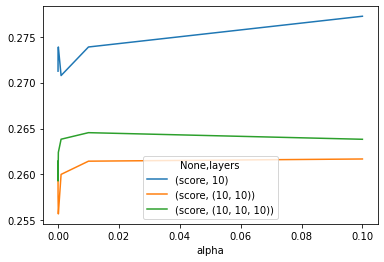

In [ ]:
mx_grid.plot()

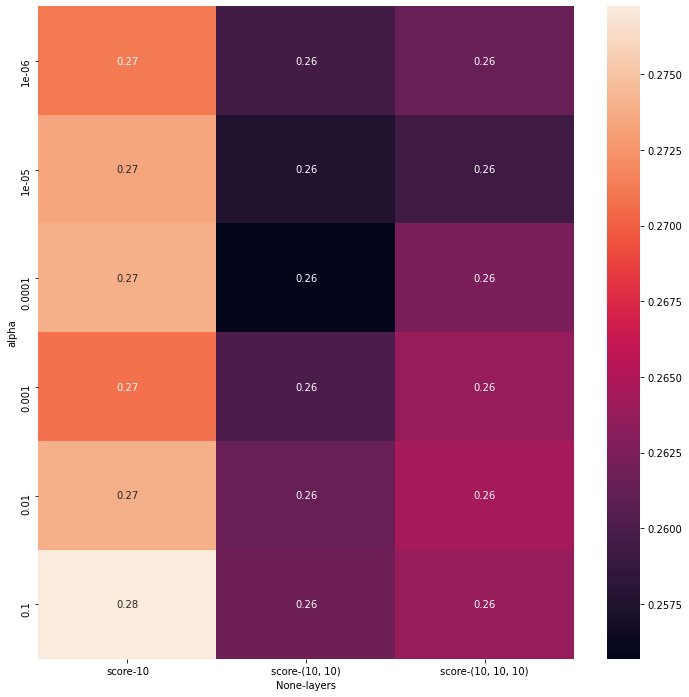

In [ ]:
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(mx_grid, annot=True)
plt.show()

In [ ]:
%%time
cv_tanh = cross_validate(grid.best_estimator_, X, y, cv=10, scoring=['accuracy','f1_micro'], return_train_score=True)

CPU times: user 28.9 s, sys: 20.5 s, total: 49.5 s
Wall time: 25.3 s


In [ ]:
df_tanh = pd.DataFrame(cv_tanh).agg(['mean','std'])
df_tanh['activation'] = 'tanh'

### relu

Definição
* relu: the rectified linear unit function, returns f(x) = max(0, x)

In [ ]:
clf_relu = MLPClassifier(solver = 'lbfgs', activation= 'relu', random_state=1)

In [ ]:
parameters = {'hidden_layer_sizes':[(10),(10,10),(10,10,10)], 'alpha': [10 ** -x for x in list(range(1,7))] }

In [ ]:
grid = GridSearchCV(clf_relu, parameters)

In [ ]:
%%time
grid.fit(X,y)

CPU times: user 3min 42s, sys: 2min 32s, total: 6min 14s
Wall time: 3min 12s


GridSearchCV(cv=None, error_score=nan,
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_fun=15000,
                                     max_iter=200, momentum=0.9,
                                     n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_state=1, shuffle=True,
                                     solver='lbfgs', tol=0.0001,
                                     validation_fraction=0.1, verbose=False,
                                     warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid

In [ ]:
grid_relu = grid

In [ ]:
grid.best_params_

{'alpha': 1e-06, 'hidden_layer_sizes': 10}

In [ ]:
grid.best_estimator_

MLPClassifier(activation='relu', alpha=1e-06, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=10, learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=1, shuffle=True, solver='lbfgs',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [ ]:
df_grid = pd.DataFrame({'alpha': grid.cv_results_['param_alpha'], 'layers': grid.cv_results_['param_hidden_layer_sizes'], 'score': grid.cv_results_['mean_test_score']})
mx_grid = df_grid.pivot(index='alpha', columns = 'layers')

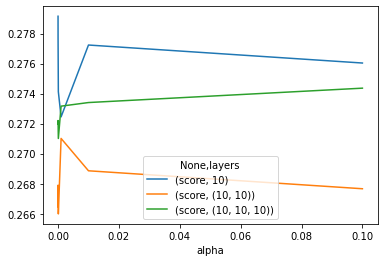

In [ ]:
mx_grid.plot()

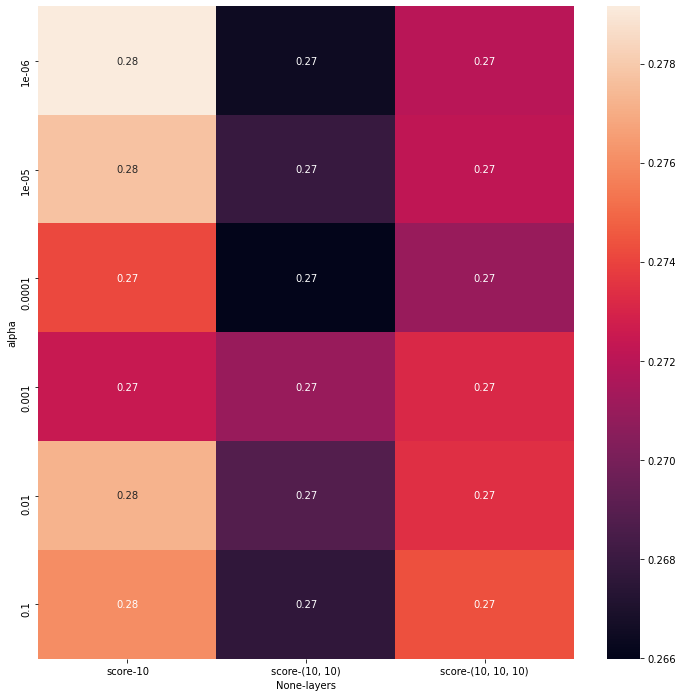

In [ ]:
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(mx_grid, annot=True)
plt.show()

In [ ]:
%%time
cv_relu = cross_validate(grid.best_estimator_, X, y, cv=10, scoring=['accuracy','f1_micro'], return_train_score=True)

CPU times: user 24.2 s, sys: 17 s, total: 41.2 s
Wall time: 21.2 s


In [ ]:
df_relu = pd.DataFrame(cv_relu).agg(['mean','std'])
df_relu['activation'] = 'relu'

## Comparativo

In [ ]:
score = df_id.append(df_log).append(df_tanh).append(df_relu)

In [ ]:
score

,fit_time,score_time,test_accuracy,train_accuracy,test_f1_micro,train_f1_micro,activation
mean,2.118917,0.003889,0.268138,0.272178,0.268138,0.272178,id
std,0.098729,0.000198,0.024815,0.003369,0.024815,0.003369,id
mean,3.420845,0.004722,0.274135,0.296598,0.274135,0.296598,log
std,0.092917,0.000544,0.041572,0.004775,0.041572,0.004775,log
mean,2.512163,0.004322,0.266469,0.301545,0.266469,0.301545,tanh
std,0.047846,0.000617,0.041162,0.006513,0.041162,0.006513,tanh
mean,2.095460,0.005338,0.261433,0.299471,0.261433,0.299471,relu
std,0.070496,0.003199,0.027796,0.006286,0.027796,0.006286,relu


### Acurácia

In [ ]:
score.loc['mean'][['train_accuracy','test_accuracy','activation']].set_index('activation')

,train_accuracy,test_accuracy
activation,,
id,0.272178,0.268138
log,0.296598,0.274135
tanh,0.301545,0.266469
relu,0.299471,0.261433


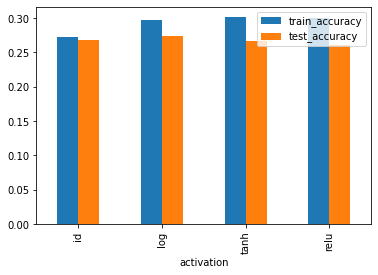

In [ ]:
score.loc['mean'][['train_accuracy','test_accuracy','activation']].set_index('activation').plot.bar()

In [ ]:
score.loc['std'][['train_accuracy','test_accuracy','activation']].set_index('activation')

,train_accuracy,test_accuracy
activation,,
id,0.003369,0.024815
log,0.004775,0.041572
tanh,0.006513,0.041162
relu,0.006286,0.027796


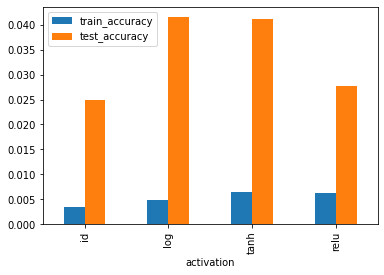

In [ ]:
 score.loc['std'][['train_accuracy','test_accuracy','activation']].set_index('activation').plot.bar()

### F1

In [ ]:
score.loc['mean'][['train_f1_micro','test_f1_micro','activation']].set_index('activation')

,train_f1_micro,test_f1_micro
activation,,
id,0.272178,0.268138
log,0.296598,0.274135
tanh,0.301545,0.266469
relu,0.299471,0.261433


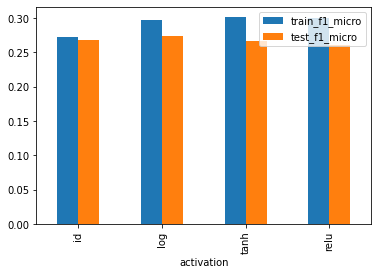

In [ ]:
score.loc['mean'][['train_f1_micro','test_f1_micro','activation']].set_index('activation').plot.bar()

In [ ]:
score.loc['std'][['train_f1_micro','test_f1_micro','activation']].set_index('activation')

,train_f1_micro,test_f1_micro
activation,,
id,0.003369,0.024815
log,0.004775,0.041572
tanh,0.006513,0.041162
relu,0.006286,0.027796


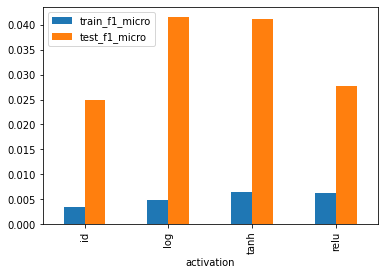

In [ ]:
score.loc['std'][['train_f1_micro','test_f1_micro','activation']].set_index('activation').plot.bar()

### Tempo

In [ ]:
score.loc['mean'][['fit_time','score_time','activation']].set_index('activation')

,fit_time,score_time
activation,,
id,2.118917,0.003889
log,3.420845,0.004722
tanh,2.512163,0.004322
relu,2.095460,0.005338


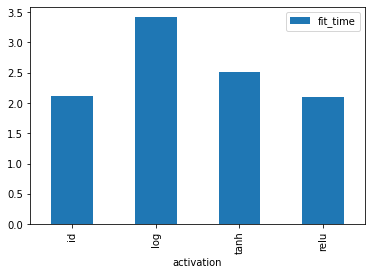

In [ ]:
score.loc['mean'][['fit_time','activation']].set_index('activation').plot.bar()

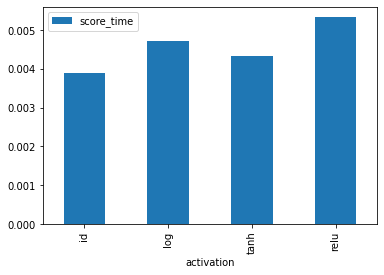

In [ ]:
score.loc['mean'][['score_time','activation']].set_index('activation').plot.bar()